# The data block API

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import * 
from fastai import *

NameError: name 'ItemList' is not defined

The data block API lets you customize how to create a [`DataBunch`](/basic_data.html#DataBunch) by isolating the underlying parts of that process in separate blocks, mainly:
- where are the inputs
- how to label them
- how to split the data into a training and validation set
- what type of [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) to create
- possible transforms to apply
- how to warp in dataloaders and create the [`DataBunch`](/basic_data.html#DataBunch)

This is a bit longer than using the factory methods but is way more flexible. As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

## Examples of use

In [`vision.data`](/vision.data.html#vision.data), we create an easy [`DataBunch`](/basic_data.html#DataBunch) suitable for classification by simply typing:

In [ ]:
# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

This is aimed at data that is in fodlers following an ImageNet style, with a train and valid directory containing each one subdirectory per class, where all the pictures are. With the data block API, the same thing is achieved like this:

In [ ]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms()#do_flip=False)
path.ls()

In [ ]:
(path/'train').ls()

To do:

- Transforms
- make imdb unsup filter work
- LabelList class methods

In [ ]:
il = ImageItemList.from_folder(path)

In [ ]:
ll = il.label_from_folder(CategoryList)

In [ ]:
# ll.transform(tfms, size=64)

In [ ]:
sd = ll.split_by_folder()

In [ ]:
ll.classes

['3', '7']

In [ ]:
# .transform(tfms, size=64)

In [ ]:
data = sd.databunch()

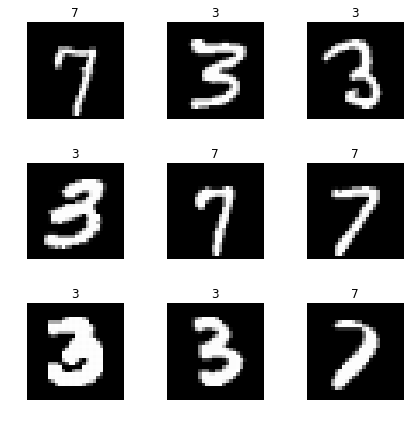

In [ ]:
data.show_batch(3, figsize=(6,6))

In [ ]:
# data = (ImageFileList.from_folder(path)  #Where to find the data? -> in path and its subfolders
#         .label_from_folder()             #How to label? -> depending on the folder of the filenames
#         .split_by_folder()               #How to split in train/valid? -> use the folders
#         .add_test_folder()               #Optionally add a test set
#         .datasets()                      #How to convert to datasets?
#         .transform(tfms, size=64)        #Data augmentation? -> use tfms with a size of 64
#         .databunch())                    #Finally? -> use the defaults for conversion to ImageDataBunch

In [ ]:
data.train_ds[0]

(Image (3, 28, 28), Category 3)

In [ ]:
data.classes

['3', '7']

Let's look at another example from [`vision.data`](/vision.data.html#vision.data) with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

With the data block API we can rewrite this like that:

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
# data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', sep = ' ', ds_tfms=planet_tfms)

In [ ]:
il = ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')

In [ ]:
ll = il.label_from_df(MultiCategoryList, sep=' ')

In [ ]:
sd = ll.random_split_by_pct()                     

In [ ]:
data = sd.databunch()

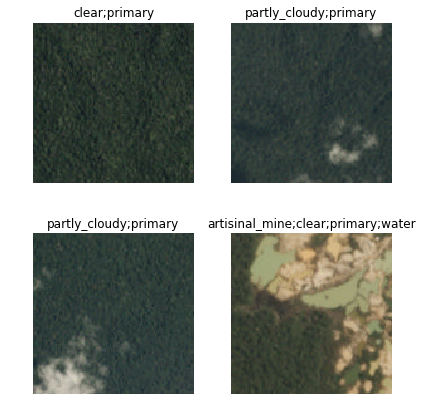

In [ ]:
data.show_batch(2, figsize=(6,6))

In [ ]:
# data = (ImageFileList.from_folder(planet)            
#         #Where to find the data? -> in planet and its subfolders
#         .label_from_csv('labels.csv', sep=' ', folder='train', suffix='.jpg')  
#         #How to label? -> use the csv file labels.csv in path, 
#         #add .jpg to the names and take them in the folder train
#         .random_split_by_pct()                     
#         #How to split in train/valid? -> randomly with the default 20% in valid
#         .datasets()
#         #How to convert to datasets? -> use ImageMultiDataset
#         .transform(planet_tfms, size=128)             
#         #Data augmentation? -> use tfms with a size of 128
#         .databunch())                          
#         #Finally? -> use the defaults for conversion to databunch

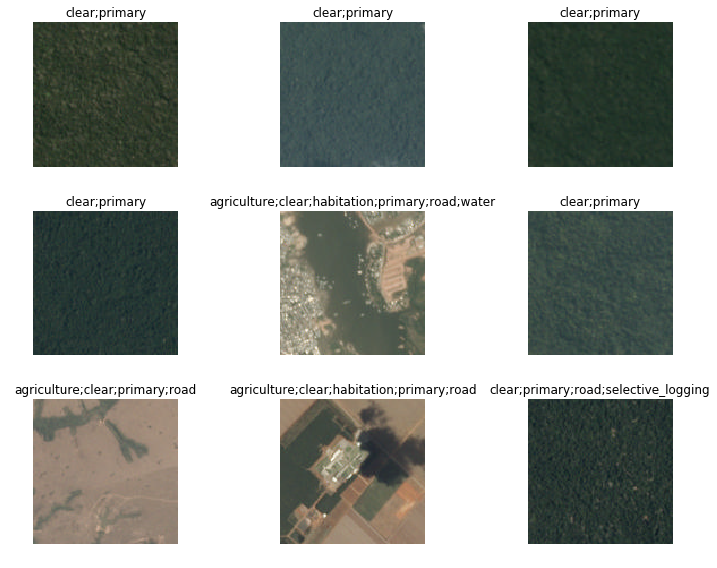

In [ ]:
data.show_batch(rows=3, figsize=(10,8))

The data block API also allows you to use dataset types for which there is no direct [`ImageDataBunch`](/vision.data.html#ImageDataBunch) factory method. For a segmentation task, for instance, we can use it to quickly get a [`DataBunch`](/basic_data.html#DataBunch). Let's take the example of the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

And we define the following function that infers the mask filename from the image filename.

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Then we can easily define a [`DataBunch`](/basic_data.html#DataBunch) using the data block API. Here we need to use `tfm_y=True` in the transform call because we need the same transforms to be applied to the target mask as were applied to the image.

In [ ]:
il = ImageItemList.from_folder(path_img)

In [ ]:
ll = il.label_from_func(ItemList, get_y_fn, create_func=open_mask)

In [ ]:
sd = ll.random_split_by_pct()                     

In [ ]:
data = sd.databunch()

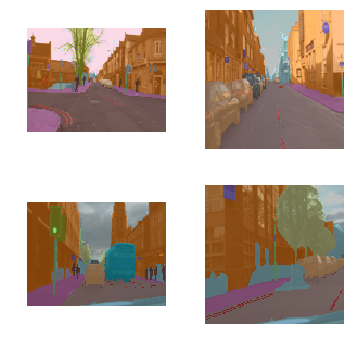

In [ ]:
data.show_batch(rows=2, figsize=(5,5))

One last example for object detection. We use our tiny sample of the [COCO dataset](http://cocodataset.org/#home) here. There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = {img:bb for img, bb in zip(images, lbl_bbox)}
get_y_func = lambda o:img2bbox[o.name]

The following code is very similar to what we saw before. The only new addition is the use of special function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes, so we need to pad them to the largest number of bounding boxes.

In [ ]:
data = (ImageFileList.from_folder(coco)
        #Where are the images? -> in coco
        .label_from_func(get_y_func)                    
        #How to find the labels? -> use get_y_func
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .datasets(ObjectDetectDataset)                  
        #How to create datasets? -> with ObjectDetectDataset
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

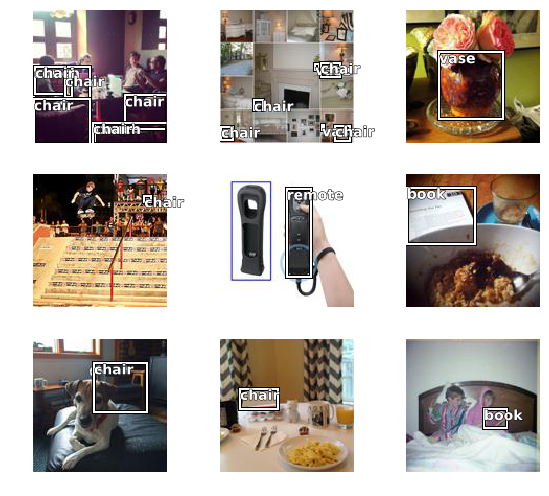

In [ ]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(8,7))

## Provide inputs

The inputs we want to feed our model are regrouped in the following class. The class contains methods to get the corresponding labels.

In [ ]:
show_doc(InputList, title_level=3, doc_string=False)

<h3 id="InputList"><code>class</code> <code>InputList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L49" class="source_link">[source]</a></h3>

> <code>InputList</code>(`items`:`Iterator`, `path`:`PathOrStr`=`'.'`) :: [`PathItemList`](/data_block.html#PathItemList)

This class regroups the inputs for our model in `items` and saves a `path` attribute which is where it will look for any files (image files, csv file with labels...)

In [ ]:
show_doc(InputList.from_folder)

<h4 id="InputList.from_folder"><code>from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L55" class="source_link">[source]</a></h4>

> <code>from_folder</code>(`path`:`PathOrStr`=`'.'`, `extensions`:`StrList`=`None`, `recurse`=`True`) → `InputList`

Get the list of files in `path` that have a suffix in `extensions`. `recurse` determines if we search subfolders.  

Note that [`InputList`](/data_block.html#InputList) is subclassed in vision by [`ImageFileList`](/vision.data.html#ImageFileList) that changes the default of `extensions` to image file extensions (which is why we used [`ImageFileList`](/vision.data.html#ImageFileList) in our previous examples).

## Labelling the inputs

All the followings are methods of [`InputList`](/data_block.html#InputList). Note that some of them are primarly intended for inputs that are filenames and might not work in general situations.

In [ ]:
show_doc(InputList.label_const)

<h4 id="InputList.label_const"><code>label_const</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L75" class="source_link">[source]</a></h4>

> <code>label_const</code>(`const`:`Any`=`0`) → `LabelList`

Label every item with `const`.  

In [ ]:
show_doc(InputList.label_from_csv)

<h4 id="InputList.label_from_csv"><code>label_from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L104" class="source_link">[source]</a></h4>

> <code>label_from_csv</code>(`csv_fname`, `header`:`Union`\[`int`, `str`, `NoneType`\]=`'infer'`, `fn_col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `label_col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `sep`:`str`=`None`, `folder`:`PathOrStr`=`'.'`, `suffix`:`str`=`None`) → `LabelList`

Look in `self.path/csv_fname` for a csv loaded with an optional `header` containing the filenames in `fn_col` to get the corresponding label in `label_col`. 

If a `folder` is specified, filenames are taken in `self.path/folder`. `suffix` is added. If `sep` is specified, splits the values in `label_col` accordingly. This method is intended for inputs that are filenames.

In [ ]:
jekyll_note("This method will only keep the filenames that are both present in the csv file and in `self.items`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method will only keep the filenames that are both present in the csv file and in `self.items`.</div>

In [ ]:
show_doc(InputList.label_from_df)

<h4 id="InputList.label_from_df"><code>label_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L93" class="source_link">[source]</a></h4>

> <code>label_from_df</code>(`df`, `fn_col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `label_col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `sep`:`str`=`None`, `folder`:`PathOrStr`=`'.'`, `suffix`:`str`=`None`) → `LabelList`

Look in `df` for the filenames in `fn_col` to get the corresponding label in `label_col`.  

In [ ]:
jekyll_note("This method will only keep the filenames that are both present in the dataframe and in `self.items`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method will only keep the filenames that are both present in the dataframe and in `self.items`.</div>

In [ ]:
show_doc(InputList.label_from_folder)

<h4 id="InputList.label_from_folder"><code>label_from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L111" class="source_link">[source]</a></h4>

> <code>label_from_folder</code>(`classes`:`StrList`=`None`) → `LabelList`

Give a label to each filename depending on its folder. If `classes` are specified, only keep those.  

In [ ]:
jekyll_note("This method looks at the last subfolder in the path to determine the classes.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the last subfolder in the path to determine the classes.</div>

In [ ]:
show_doc(InputList.label_from_func)

<h4 id="InputList.label_from_func"><code>label_from_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L79" class="source_link">[source]</a></h4>

> <code>label_from_func</code>(`func`:`Callable`) → `LabelList`

Apply `func` to every input to get its label.  

This method is primarly intended for inputs that are filenames, but could work in other settings.

In [ ]:
show_doc(InputList.label_from_re)

<h4 id="InputList.label_from_re"><code>label_from_re</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L83" class="source_link">[source]</a></h4>

> <code>label_from_re</code>(`pat`:`str`, `full_path`:`bool`=`False`) → `LabelList`

Apply the re in `pat` to determine the label of every filename.  If `full_path`, search in the full name.  

In [ ]:
show_doc(LabelList, title_level=3, doc_string=False)

<h3 id="LabelList"><code>class</code> <code>LabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L117" class="source_link">[source]</a></h3>

> <code>LabelList</code>(`items`:`Iterator`, `path`:`PathOrStr`=`'.'`, `parent`:[`InputList`](/data_block.html#InputList)=`None`) :: [`PathItemList`](/data_block.html#PathItemList)

A list of labelled inputs in `items` (expected to be tuples of input, label) with a `path` attribute. This class contains methods to create `SplitDataset`.

In [ ]:
show_doc(LabelList.from_csv)

<h4 id="LabelList.from_csv"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L138" class="source_link">[source]</a></h4>

> <code>from_csv</code>(`path`:`PathOrStr`, `csv_fname`:`PathOrStr`, `input_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `label_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `header`:`str`=`'infer'`, `label_delim`:`str`=`None`)

Create a `LabelDataset` in `path` by reading `input_cols` and `label_cols` in the csv in `path/csv_name` opened with `header`. If `label_delim` is specified, splits the tags in `label_cols` accordingly. 

In [ ]:
show_doc(LabelList.from_csvs)

<h4 id="LabelList.from_csvs"><code>from_csvs</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L147" class="source_link">[source]</a></h4>

> <code>from_csvs</code>(`path`:`PathOrStr`, `csv_fnames`:`Collection`\[`PathOrStr`\], `input_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `label_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `header`:`str`=`'infer'`) → `LabelList`

Create a `LabelDataset` in `path` by reading `input_cols` and `label_cols` in the csvs in `path/csv_names` opened with `header`. If `label_delim` is specified, splits the tags in `label_cols` accordingly. 

In [ ]:
show_doc(LabelList.from_df)

<h4 id="LabelList.from_df"><code>from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L130" class="source_link">[source]</a></h4>

> <code>from_df</code>(`path`:`PathOrStr`, `df`:`DataFrame`, `input_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `label_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `label_delim`:`str`=`None`)

Create a `LabelDataset` in `path` by reading `input_cols` and `label_cols` in `df`. If `label_delim` is specified, splits the tags in `label_cols` accordingly. 

## Split the data between train and validation.

The following functions are methods of [`LabelList`](/data_block.html#LabelList), to create a [`SplitData`](/data_block.html#SplitData) in different ways.

In [ ]:
show_doc(LabelList.random_split_by_pct)

<h4 id="LabelList.random_split_by_pct"><code>random_split_by_pct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L199" class="source_link">[source]</a></h4>

> <code>random_split_by_pct</code>(`valid_pct`:`float`=`0.2`) → `SplitData`

Split the items randomly by putting `valid_pct` in the validation set.  

In [ ]:
show_doc(LabelList.split_by_files)

<h4 id="LabelList.split_by_files"><code>split_by_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L169" class="source_link">[source]</a></h4>

> <code>split_by_files</code>(`valid_names`:[`InputList`](/data_block.html#InputList)) → `SplitData`

Split the data by using the names in `valid_names` for validation.  

In [ ]:
show_doc(LabelList.split_by_fname_file)

<h4 id="LabelList.split_by_fname_file"><code>split_by_fname_file</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L175" class="source_link">[source]</a></h4>

> <code>split_by_fname_file</code>(`fname`:`PathOrStr`, `path`:`PathOrStr`=`None`) → `SplitData`

Split the data by using the file names in `fname` for the validation set. `path` will override `self.path`. This method won't work if you inputs aren't filenames. 

In [ ]:
show_doc(LabelList.split_by_folder)

<h4 id="LabelList.split_by_folder"><code>split_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L189" class="source_link">[source]</a></h4>

> <code>split_by_folder</code>(`train`:`str`=`'train'`, `valid`:`str`=`'valid'`) → `SplitData`

Split the data depending on the folder (`train` or `valid`) in which the filenames are. This method won't work if you inputs aren't filenames. 

In [ ]:
jekyll_note("This method looks at the folder immediately after `self.path` for `valid` and `train`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the folder immediately after `self.path` for `valid` and `train`.</div>

In [ ]:
show_doc(LabelList.split_by_idx)

<h4 id="LabelList.split_by_idx"><code>split_by_idx</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L183" class="source_link">[source]</a></h4>

> <code>split_by_idx</code>(`valid_idx`:`Collection`\[`int`\]) → `SplitData`

Split the data according to the indexes in `valid_idx`.  

In [ ]:
show_doc(LabelList.split_by_valid_func)

<h4 id="LabelList.split_by_valid_func"><code>split_by_valid_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L164" class="source_link">[source]</a></h4>

> <code>split_by_valid_func</code>(`func`:`Callable`) → `SplitData`

Split the data by result of `func` (which returns `True` for validation set)  

In [ ]:
show_doc(SplitData, title_level=3)

<h3 id="SplitData"><code>class</code> <code>SplitData</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L205" class="source_link">[source]</a></h3>

> <code>SplitData</code>(`path`:`PathOrStr`, `train`:[`LabelList`](/data_block.html#LabelList), `valid`:[`LabelList`](/data_block.html#LabelList), `test`:[`LabelList`](/data_block.html#LabelList)=`None`)

A [`LabelList`](/data_block.html#LabelList) for each of `train` and `valid` (optional `test`), and method to get `datasets`  

You won't normally construct a [`SplitData`](/data_block.html#SplitData) yourself, but instead will use one of the `split*` methods in [`LabelList`](/data_block.html#LabelList).

In [ ]:
show_doc(LabelList.from_csv)

<h4 id="LabelList.from_csv"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L138" class="source_link">[source]</a></h4>

> <code>from_csv</code>(`path`:`PathOrStr`, `csv_fname`:`PathOrStr`, `input_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `label_cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `header`:`str`=`'infer'`, `label_delim`:`str`=`None`)

Create a `LabelDataset` in `path` by reading `input_cols` and `label_cols` in the csv in `path/csv_name` opened with `header`. If `label_delim` is specified, splits the tags in `label_cols` accordingly. 

In [ ]:
show_doc(SplitData.add_test)

<h4 id="SplitData.add_test"><code>add_test</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L240" class="source_link">[source]</a></h4>

> <code>add_test</code>(`test`:[`ItemList`](/data_block.html#ItemList), `label`:`Any`=`None`)

Add test set containing items from `test` and an arbitrary label  

## Create datasets

To create the datasets from [`SplitData`](/data_block.html#SplitData) we have the following class method.

In [ ]:
show_doc(SplitData.datasets)

<h4 id="SplitData.datasets"><code>datasets</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L231" class="source_link">[source]</a></h4>

> <code>datasets</code>(`dataset_cls`:`type`=`None`, `kwargs`) → `SplitDatasets`

Create datasets from the underlying data using `dataset_cls` and passing along the `kwargs`.  

In [ ]:
show_doc(SplitDatasets, title_level=3)

<h3 id="SplitDatasets"><code>class</code> <code>SplitDatasets</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L248" class="source_link">[source]</a></h3>

> <code>SplitDatasets</code>(`path`:`PathOrStr`, `train_ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `valid_ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `test_ds`:`Optional`\[[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)\]=`None`)

A class regrouping `train_ds`, a `valid_ds` and maybe a `train_ds` dataset, inside a `path`.  

This class can be constructed directly from one of the following factory methods.

In [ ]:
show_doc(SplitDatasets.from_single)

<h4 id="SplitDatasets.from_single"><code>from_single</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L280" class="source_link">[source]</a></h4>

> <code>from_single</code>(`path`:`PathOrStr`, `ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) → `SplitDatasets`

Factory method that uses `ds` for both valid and train, and passes `path`.  

In [ ]:
show_doc(SplitDatasets.single_from_c)

<h4 id="SplitDatasets.single_from_c"><code>single_from_c</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L290" class="source_link">[source]</a></h4>

> <code>single_from_c</code>(`path`:`PathOrStr`, `c`:`int`) → `SplitDatasets`

Factory method that passes a [`DatasetBase`](/basic_data.html#DatasetBase) on `c` to `from_single`.  

In [ ]:
show_doc(SplitDatasets.single_from_classes)

<h4 id="SplitDatasets.single_from_classes"><code>single_from_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L285" class="source_link">[source]</a></h4>

> <code>single_from_classes</code>(`path`:`PathOrStr`, `classes`:`StrList`) → `SplitDatasets`

Factory method that passes a [`SingleClassificationDataset`](/basic_data.html#SingleClassificationDataset) on `classes` to `from_single`.  

Then we can build the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) around our [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) like this.

In [ ]:
show_doc(SplitDatasets.dataloaders)

<h4 id="SplitDatasets.dataloaders"><code>dataloaders</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L276" class="source_link">[source]</a></h4>

> <code>dataloaders</code>(`kwargs`) → `Collection`\[[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)\]

Create dataloaders with the inner datasets, pasing the `kwargs`.  

The methods `img_transform` and `img_databunch` used earlier are documented in [`vision.data`](/vision.data.html#vision.data).

## Utility classes and functions

In [ ]:
show_doc(ItemList, title_level=3)

<h3 id="ItemList"><code>class</code> <code>ItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L12" class="source_link">[source]</a></h3>

> <code>ItemList</code>(`items`:`Iterator`)

A collection of items with `__len__` and `__getitem__` with `ndarray` indexing semantics.  

In [ ]:
show_doc(PathItemList, title_level=3)

<h3 id="PathItemList"><code>class</code> <code>PathItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L19" class="source_link">[source]</a></h3>

> <code>PathItemList</code>(`items`:`Iterator`, `path`:`PathOrStr`=`'.'`) :: [`ItemList`](/data_block.html#ItemList)

An [`ItemList`](/data_block.html#ItemList) with a `path` attribute.  

In [ ]:
show_doc(get_files)

<h4 id="get_files"><code>get_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L6" class="source_link">[source]</a></h4>

> <code>get_files</code>(`c`:`PathOrStr`, `extensions`:`StrList`=`None`, `recurse`:`bool`=`False`) → `FilePathList`

Return list of files in `c` that have a suffix in `extensions`. `recurse` determines if we search subfolders.  

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(LabelList.split_by_list)

<h4 id="LabelList.split_by_list"><code>split_by_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L161" class="source_link">[source]</a></h4>

> <code>split_by_list</code>(`train`, `valid`)

In [ ]:
show_doc(SplitData.dataset_cls)

<h4 id="SplitData.dataset_cls"><code>dataset_cls</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L229" class="source_link">[source]</a></h4>

> <code>dataset_cls</code>()

In [ ]:
show_doc(InputList.create_label_list)

<h4 id="InputList.create_label_list"><code>create_label_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L72" class="source_link">[source]</a></h4>

> <code>create_label_list</code>(`items`:`Iterator`) → `LabelList`

## New Methods - Please document or move to the undocumented section